In [3]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple
from PIL import Image
from numpy.fft import fft2, fftshift, ifftshift

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip,RandomCrop, Input, LeakyReLU

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

seed = 1235
tf.random.set_seed(seed)

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Functions

In [5]:
def plot_metrics(model, *, names=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc']):
    """
    Plot training and validation metrics from a model's training history.
    
    This function creates a figure with three subplots showing the progression of different
    metrics (loss, accuracy, and AUC) over training epochs. Each subplot displays both the
    training and validation metrics for easy comparison.
    
    Parameters
    ----------
    model : tf.keras.callbacks.History
        The history object returned by model.fit() containing the training metrics.
        Should have the specified metrics in its history dictionary.
    names : list of str, optional
        List of metric names to plot. Should contain 6 strings in the order:
        [training_loss, val_loss, training_acc, val_acc, training_auc, val_auc].
        Default is ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc'].
        
    Returns
    -------
    None
        The function displays the plot but doesn't return any values.
        
    Raises
    ------
    KeyError
        If any of the specified metric names are not found in model.history.
    ValueError
        If the names list doesn't contain exactly 6 metrics.
        
    Examples
    --------
    >>> history = model.fit(x_train, y_train, validation_data=(x_val, y_val))
    >>> plot_metrics(history)
    
    >>> # With custom metric names
    >>> plot_metrics(history, names=['loss', 'val_loss', 'binary_accuracy', 
                                   'val_binary_accuracy', 'auc', 'val_auc'])
    
    Notes
    -----
    - The function creates a 1x3 grid of subplots with the following arrangement:
        1. Loss metrics (left)
        2. Accuracy metrics (middle)
        3. AUC metrics (right)
    - Training metrics are plotted in teal
    - Validation metrics are plotted in orange
    - The figure is created with a size of 10x5 inches and 300 DPI
    """
    # Validate input
    if len(names) != 6:
        raise ValueError("Expected 6 metric names, got {len(names)}")
    
    # Pre-fetch all data at once to avoid multiple dictionary lookups
    try:
        metrics_data = {name: model.history[name] for name in names}
    except KeyError as e:
        raise KeyError(f"Metric {e} not found in model history. Available metrics: {list(model.history.keys())}")
    
    # Create figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=300)
    plt.suptitle('Performance Metrics', fontsize=15)
    
    # Define plot configurations
    plot_configs = [
        {'idx': 0, 'metrics': names[0:2], 'title': 'Loss', 'colors': ['teal', 'orange']},
        {'idx': 1, 'metrics': names[2:4], 'title': 'Accuracy', 'colors': ['teal', 'orange']},
        {'idx': 2, 'metrics': names[4:6], 'title': 'AUC', 'colors': ['teal', 'orange']}
    ]
    
    # Create plots using a loop
    for config in plot_configs:
        ax = axes[config['idx']]
        for metric, color in zip(config['metrics'], config['colors']):
            ax.plot(metrics_data[metric], color=color, label=metric)
        ax.set_title(config['title'], fontsize=10)
        ax.set_xlabel('Epochs')
        ax.legend(loc="upper left")
    
    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, title="ROC Curve"):
    """
    Plots the ROC curve and computes the AUC.

    Parameters:
    - y_true: True labels (array-like, shape = [n_samples])
    - y_pred_prob: Predicted probabilities for the positive class (array-like, shape = [n_samples])
    - title: Title of the plot (default: "ROC Curve")
    """
    # Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    
    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line for random guess
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [7]:
def get_lables(model, test):
    """
    Extracts the true labels and predictions from a model and test dataset.

    Args:
        model (tf.keras.Model): The trained TensorFlow/Keras model used for prediction.
        test (tf.data.Dataset): A test dataset containing images and labels, typically in batch format.

    Returns:
        tuple:
            - y_true (np.ndarray): A NumPy array containing the true labels for all samples in the test dataset.
            - y_pred (np.ndarray): A NumPy array containing the predicted labels (or probabilities) from the model.

    Notes:
        - This function processes the test dataset batch-by-batch, extracts the true labels, 
          and concatenates them into a single array.
        - Predictions are generated for the entire test dataset using the model's `predict` method.

    Example:
        ```
        # Assuming `model` is a trained Keras model and `test_dataset` is a tf.data.Dataset
        y_true, y_pred = get_labels(model, test_dataset)

        # Save the true labels as a NumPy file
        np.save('true_labels.npy', y_true)
        ```
    """
    
    y_pred = model.predict(test)
    
    test_data_list = list(test)
    labels = []
    for batch in test_data_list:
        images, label = batch
        # Process your batch here
        labels.append(label.numpy())
        #print(images.shape, labels.shape)
    y_true = np.concatenate(labels, axis=0)
    return y_true, y_pred
    
    #To save the numpy arrays
    #np.save('EFlow Images/Notebooks', y_true)

# Vortex Phase Transformation

In [17]:
def vortex_phase_transformation(image, label):
    image = tf.cast(image, tf.float32)

    # 2D FFT
    fft_image = tf.signal.fft2d(tf.complex(image, tf.zeros_like(image)))
    phase_image = tf.math.angle(fft_image)

    return phase_image, label

def visualize_images(dataset_original, dataset_transformed, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(6, 2 * num_images))

    dataset_original_iter = dataset_original.as_numpy_iterator()
    dataset_transformed_iter = dataset_transformed.as_numpy_iterator()

    for i in range(num_images):
        orig_batch = next(dataset_original_iter)
        trans_batch = next(dataset_transformed_iter)

        orig_img = orig_batch[0][i]  # Extract i-th image from batch
        trans_img = trans_batch[0][i]  # Extract i-th transformed image from batch

        # Normalize phase image for better visualization (scale to [0,1])
        trans_img = (trans_img - np.min(trans_img)) / (np.max(trans_img) - np.min(trans_img))

        # Remove extra channel dimension
        orig_img = np.squeeze(orig_img)  
        trans_img = np.squeeze(trans_img)  

        # Plot original image
        axes[i, 0].imshow(orig_img, cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Plot transformed (FFT Phase) image
        axes[i, 1].imshow(trans_img, cmap='gray')
        axes[i, 1].set_title("FFT Phase")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


# 2. Loading the Dataset

Found 2415 files belonging to 2 classes.


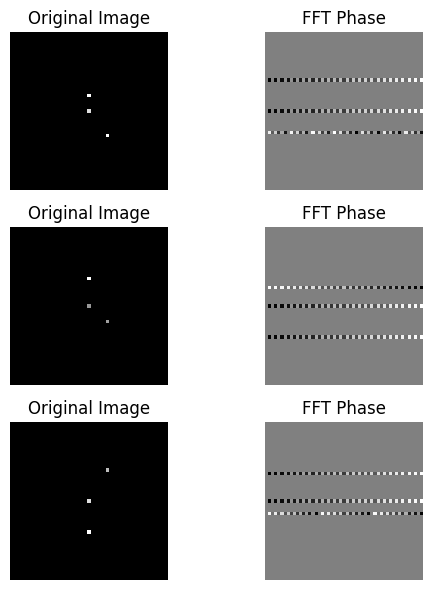

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data_dir = '/teamspace/studios/this_studio/all/EFlow Images/btagged_greyScale_images_CNN/btagged_greyScale_images'
batch_size = 100
image_size = (51, 51)

data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=seed,
    batch_size=batch_size,
    color_mode='grayscale',
    image_size=image_size
)

data = data.map(lambda x, y: (x / 255.0, y))

data_transformed = data.map(vortex_phase_transformation)

visualize_images(data, data_transformed, num_images=3)

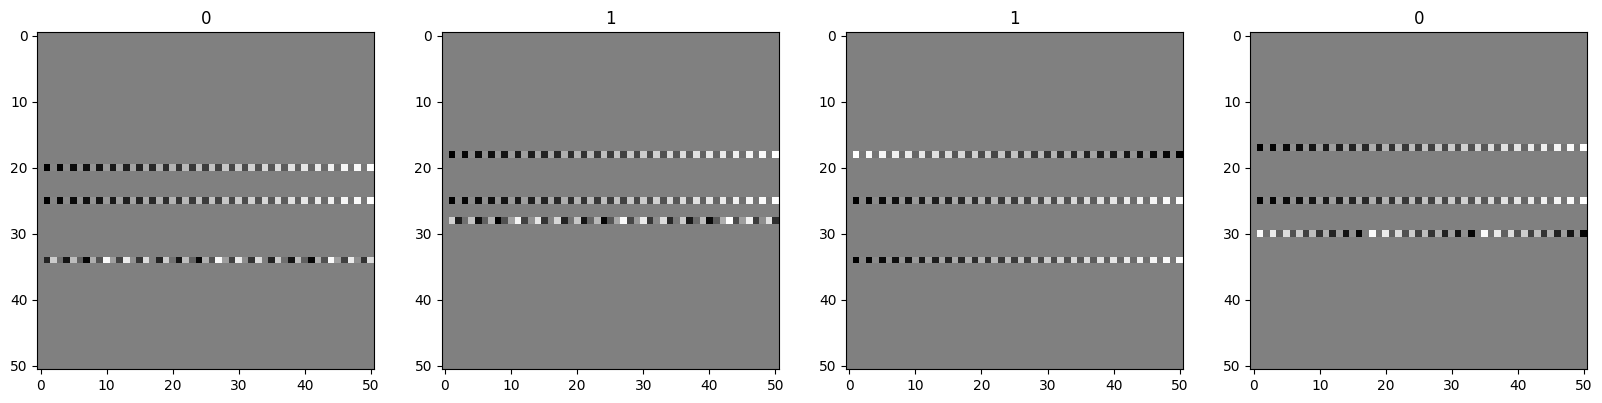

In [19]:
data_iterator = iter(data_transformed)
batch = next(data_iterator)

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    img = img.numpy().squeeze()  # Ensure correct shape (51,51)
    ax[idx].imshow(img, cmap='gray')  # Phase image is single-channel
    ax[idx].title.set_text(batch[1][idx].numpy())

plt.show()

In [20]:
data_iterator.next()[0].shape

TensorShape([100, 51, 51, 1])

## 2.1 Train-Test Split

In [21]:
train_size = int(len(data_transformed) * 0.7)  # 70% training
val_size = int(len(data_transformed) * 0.2)  # 20% validation
test_size = int(len(data_transformed) * 0.1)  # 10% testing

train = data_transformed.take(train_size)
val = data_transformed.skip(train_size).take(val_size)
test = data_transformed.skip(train_size + val_size).take(test_size)

# CNN Model

In [22]:
model = Sequential()

model.add(Input(shape=(51, 51, 1)))
model.add(Conv2D(32, (5,5), 1, activation = 'relu'))
model.add(MaxPooling2D(strides=1))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 67712)             0         
                                                                 
 dense (Dense)               (None, 512)               34669056  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 34670401 (132.26 MB)
Trainable params: 34670401 (132.26 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [23]:
model.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])


hist = model.fit(train,
                 epochs = 10,
                 validation_data = val)

Epoch 1/10
17/17 [==============================] - 6s 264ms/step - loss: 1.9035 - accuracy: 0.5529 - precision: 0.3977 - recall: 0.4545 - auc: 0.5587 - true_positives: 280.0000 - false_positives: 424.0000 - true_negatives: 660.0000 - false_negatives: 336.0000 - val_loss: 0.6653 - val_accuracy: 0.6100 - val_precision: 0.4834 - val_recall: 0.7892 - val_auc: 0.7094 - val_true_positives: 146.0000 - val_false_positives: 156.0000 - val_true_negatives: 159.0000 - val_false_negatives: 39.0000
Epoch 2/10
17/17 [==============================] - 5s 265ms/step - loss: 0.6273 - accuracy: 0.6635 - precision: 0.5710 - recall: 0.3053 - auc: 0.6525 - true_positives: 189.0000 - false_positives: 142.0000 - true_negatives: 939.0000 - false_negatives: 430.0000 - val_loss: 0.6119 - val_accuracy: 0.6860 - val_precision: 0.5667 - val_recall: 0.7196 - val_auc: 0.7294 - val_true_positives: 136.0000 - val_false_positives: 104.0000 - val_true_negatives: 207.0000 - val_false_negatives: 53.0000
Epoch 3/10
17/17 [

2/2 [==============================] - 0s 43ms/step


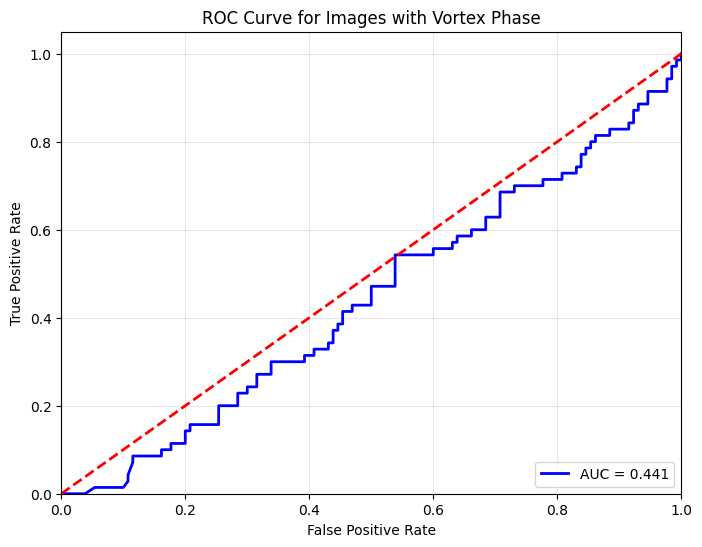

In [24]:
y_true, y_pred = get_lables(model, test)
plot_roc_curve(y_true, y_pred, title = 'ROC Curve for Images with Vortex Phase')

2/2 [==============================] - 0s 49ms/step - loss: 0.5265 - accuracy: 0.7600 - precision: 0.7692 - recall: 0.5263 - auc: 0.7837 - true_positives: 40.0000 - false_positives: 12.0000 - true_negatives: 112.0000 - false_negatives: 36.0000


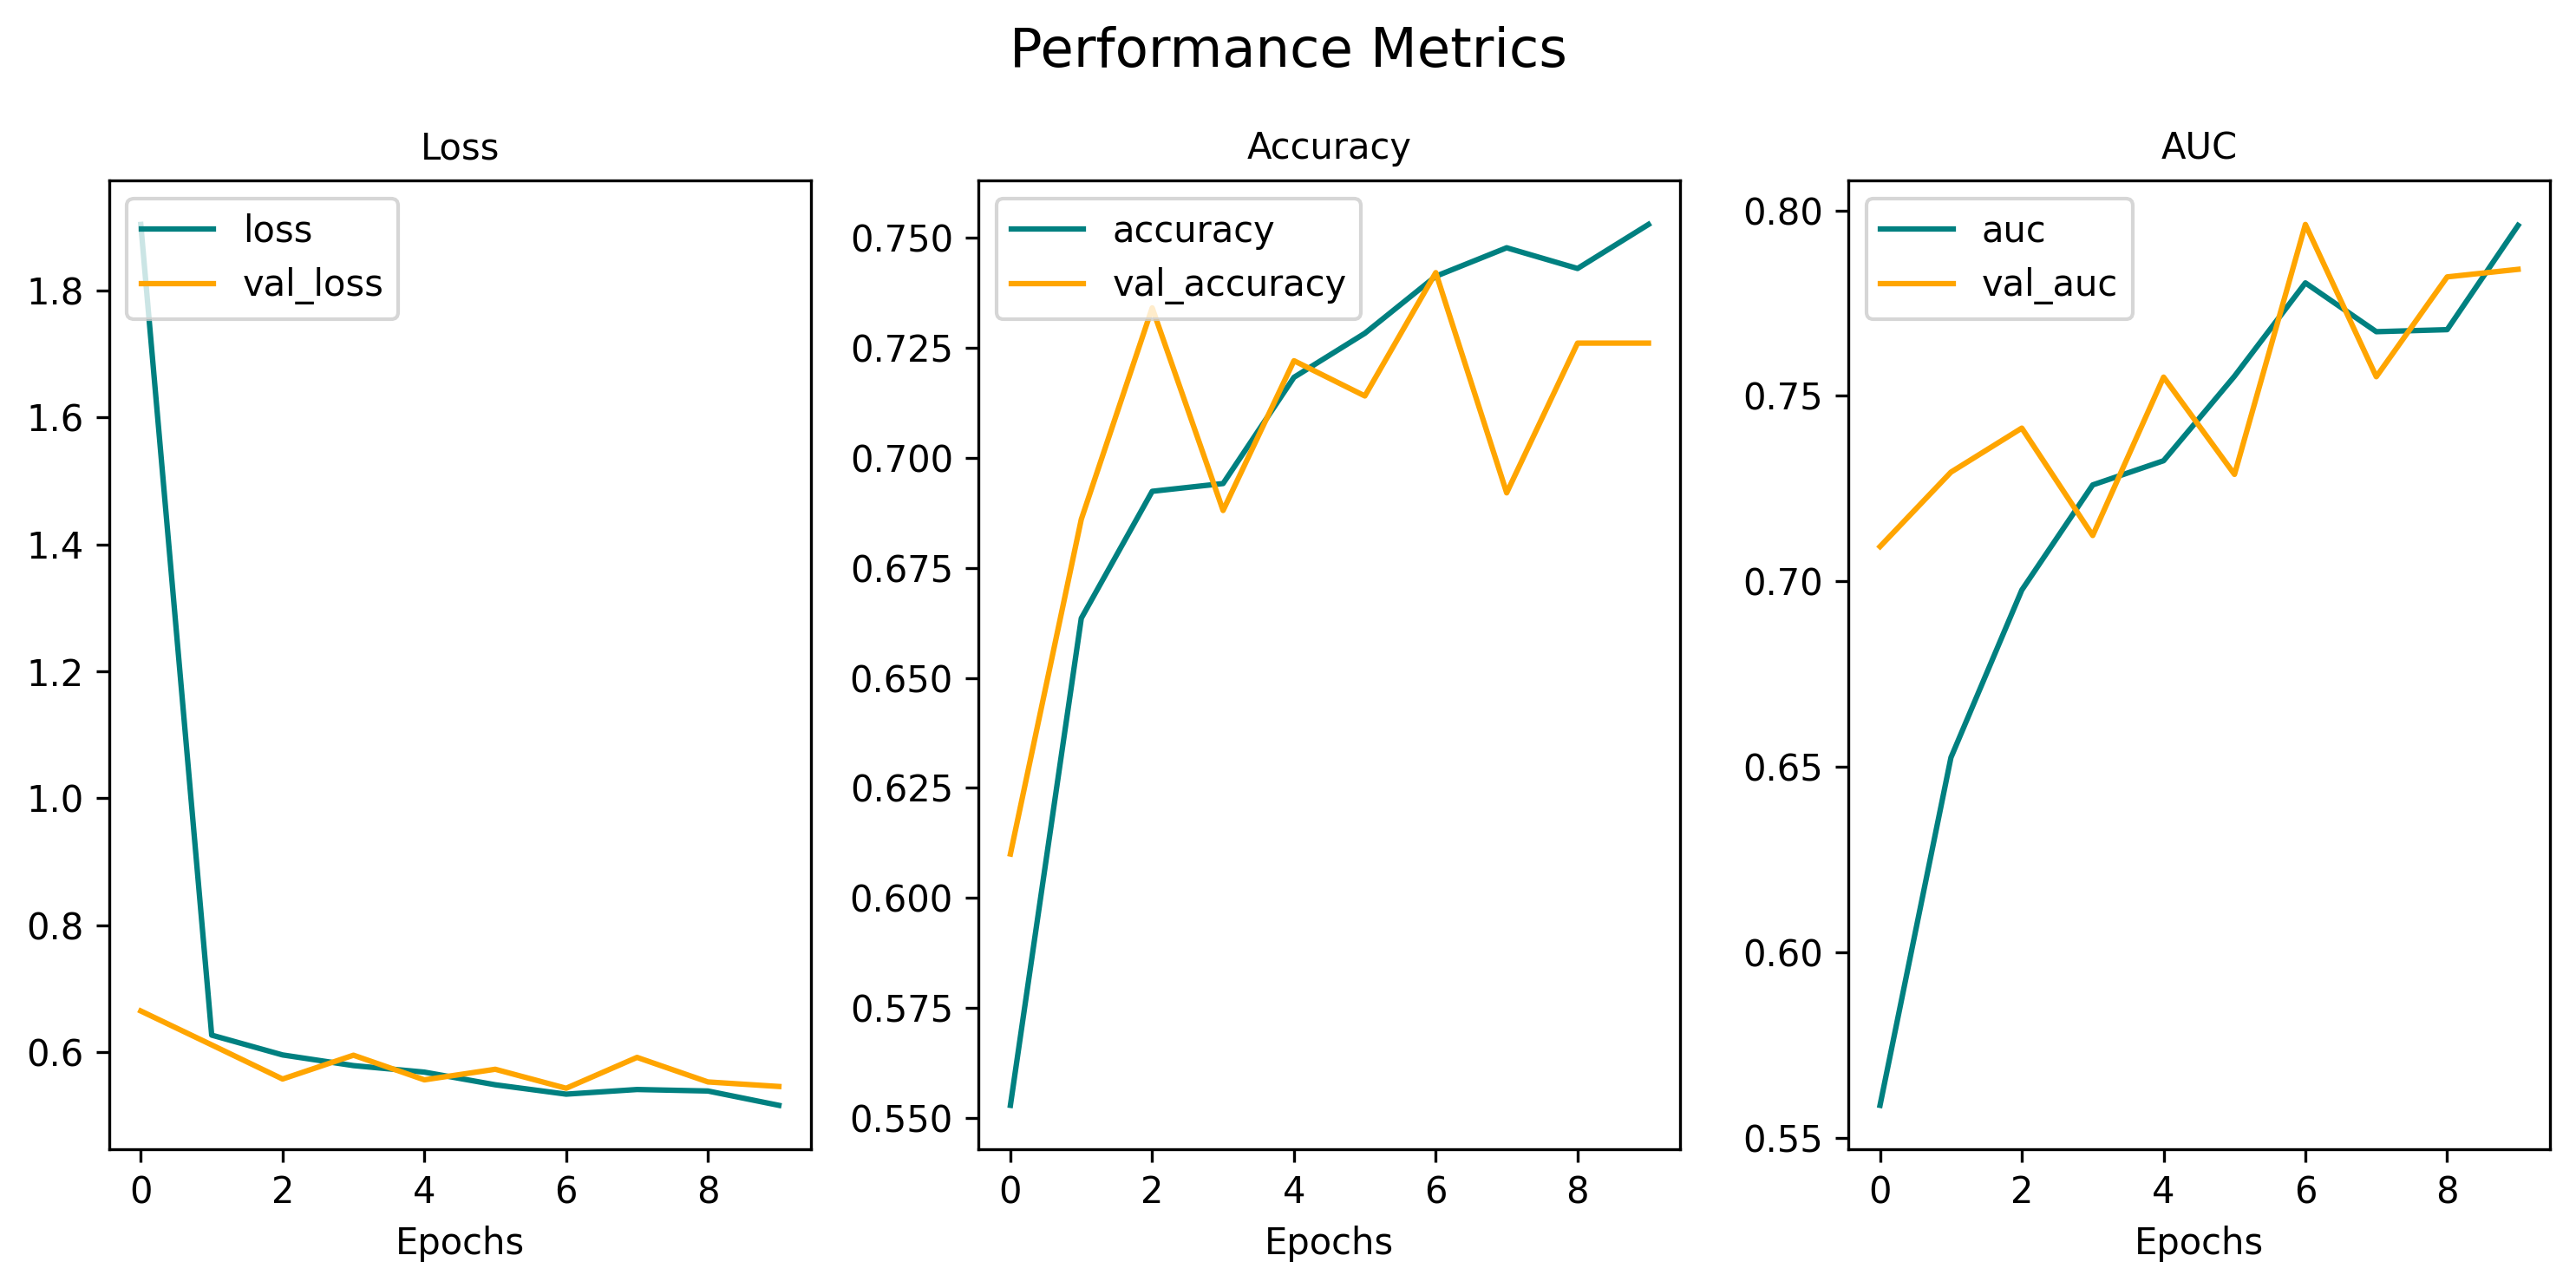

In [26]:
eval_metrices = model.evaluate(test)
plot_metrics(hist, names = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc'])

# GradCAM Function

In [44]:
def preprocess_image(img_path, target_size):
    # Add error handling for file existence
    try:
        img = tf.keras.preprocessing.image.load_img(
            img_path, 
            color_mode='grayscale', 
            target_size=target_size
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0, 1]
        return np.expand_dims(img_array, axis=0)
    except Exception as e:
        raise Exception(f"Error loading image: {str(e)}")

def generate_gradcam(image_path, model, grad_model, target_size=(51, 51)):
    # Load and preprocess the image
    image = preprocess_image(image_path, target_size)
    
    # Get the prediction
    predictions = model(image)
    predicted_class = 1 if predictions[0] > 0.5 else 0
    print(f"Predicted class: {predicted_class} (confidence: {predictions[0][0]:.3f})")
    
    # Generate gradients
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, 0]
    
    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        raise ValueError("Gradients are None. Check model architecture.")
    
    # Calculate pooled gradients and heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # Process heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    # Load and process original image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Failed to load image for visualization")
    
    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    
    # Convert grayscale to RGB for visualization
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Create superimposed image
    superimposed = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)
    
    return superimposed, heatmap_resized, predicted_class, predictions[0][0]

Predicted class: 0 (confidence: 0.135)


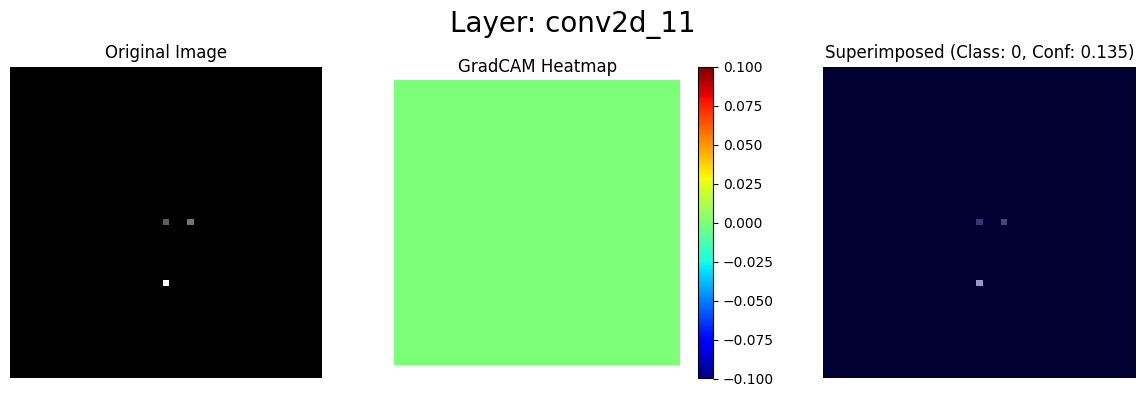

In [45]:
try:
    # Creating the grad model
    last_layer_name = 'conv2d_11'
    grad_model = tf.keras.Model(
        inputs=[model3.input],
        outputs=[
            model3.get_layer(last_layer_name).output,
            model3.output
        ]
    )
except Exception as e:
    print(f"Error generating GradModel: {str(e)}")
    


try:
    image_path = "/teamspace/studios/this_studio/all/EFlow Images/btagged_greyScale_images_CNN/btagged_greyScale_images/background/record_859.png"
    
    # Generate GradCAM
    superimposed_img, heatmap, pred_class, confidence = generate_gradcam(
        image_path, 
        model3, 
        grad_model
    )
    
    # Plotting
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Layer: {last_layer_name}', fontsize = 20)
    # Original image
    plt.subplot(131)
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.colorbar()
    plt.axis('off')
    
    # Superimposed
    plt.subplot(133)
    plt.imshow(superimposed_img[..., ::-1])  # Convert BGR to RGB
    plt.title(f'Superimposed (Class: {pred_class}, Conf: {confidence:.3f})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error generating GradCAM: {str(e)}")